## Importing cryptocurrency vs real currency comparion (API)
## Bitcoin vs EUR

- Use https://www.coingecko.com/en/api to import Bitcoin vs EUR from 16-06-2019 to 16-16-2020
- Convert results to percentages so they can be plotted against other currency combinations

In [1]:
import requests
import pandas as pd
import json

In [2]:
# Defining coingecko API url with variables for cryptocurrency and real world currency

def get_api(cryp_currency, real_currency):
    base = 'https://api.coingecko.com/api/v3/'
    url = ''.join(base + 'coins/' + cryp_currency + '/market_chart/range?vs_currency=' + real_currency + '&from=1560643200&to=1592265600')
    
    return url

api_call = get_api('bitcoin', 'eur')


In [3]:
# Importing data

def to_json_format(api):
    result = requests.get(api)
    json_data = result.json()
    
    return json_data

json_obj = to_json_format(api_call)


In [4]:
# Creating dataframe

df = pd.DataFrame(json_obj['prices'], columns=['date', 'price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    367 non-null    int64  
 1   price   367 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.9 KB


In [5]:
## Converting 'time' column to dtype timestamp

df['date'] = pd.to_datetime(df['date'], unit='ms')
df

,date,price
0,2019-06-16,7853.059952
1,2019-06-17,8006.856370
2,2019-06-18,8298.389613
3,2019-06-19,8121.834445
4,2019-06-20,8264.077225
...,...,...
362,2020-06-12,8258.589886
363,2020-06-13,8413.320493
364,2020-06-14,8413.267326
365,2020-06-15,8304.428332


## Creating function to input cryptocurrency and real_world currency and output dataframe of market values for the timeframe 16-06-2019 to 16-06-2020

In [6]:
def crypto_vs_real(crypto_currency, real_currency):
    api_call = get_api(crypto_currency, real_currency)
    json_obj = to_json_format(api_call)
    
    df = pd.DataFrame(json_obj['prices'], columns=['date', real_currency])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    
    return df
    
df_bc_eur = crypto_vs_real('bitcoin', 'eur')
df_bc_eur.head()

,date,eur
0,2019-06-16,7853.059952
1,2019-06-17,8006.856370
2,2019-06-18,8298.389613
3,2019-06-19,8121.834445
4,2019-06-20,8264.077225


In [7]:
# Getting data for bitcoin vs USD and CNY

df_bc_usd = crypto_vs_real('bitcoin', 'usd')
df_bc_usd.head()

,date,usd
0,2019-06-16,8818.609507
1,2019-06-17,8978.772588
2,2019-06-18,9312.868295
3,2019-06-19,9094.021746
4,2019-06-20,9285.928674


In [8]:
df_bc_cny = crypto_vs_real('bitcoin', 'cny')
df_bc_cny.head()

,date,cny
0,2019-06-16,61072.398279
1,2019-06-17,62183.333561
2,2019-06-18,64499.063236
3,2019-06-19,62778.760320
4,2019-06-20,64106.337196


In [9]:
# Merging dataframes for EUR, USD and CNY

df_compare_bc = df_bc_eur.merge(df_bc_usd).merge(df_bc_cny)

df_compare_bc.head()

,date,eur,usd,cny
0,2019-06-16,7853.059952,8818.609507,61072.398279
1,2019-06-17,8006.856370,8978.772588,62183.333561
2,2019-06-18,8298.389613,9312.868295,64499.063236
3,2019-06-19,8121.834445,9094.021746,62778.760320
4,2019-06-20,8264.077225,9285.928674,64106.337196


In [32]:
# Exporting 

df_compare_bc.to_json('../data/clean_bitcoin_exchange_not_normalised.json')

## Visualizing the data

In [10]:
# Creating Plot

import matplotlib.pyplot as plt
%matplotlib inline

df_compare_bc.set_index('date', inplace=True)


In [11]:
df_compare_bc.head()

,eur,usd,cny
date,,,
2019-06-16,7853.059952,8818.609507,61072.398279
2019-06-17,8006.856370,8978.772588,62183.333561
2019-06-18,8298.389613,9312.868295,64499.063236
2019-06-19,8121.834445,9094.021746,62778.760320
2019-06-20,8264.077225,9285.928674,64106.337196


Text(0, 0.5, 'Value of Bitcoin')

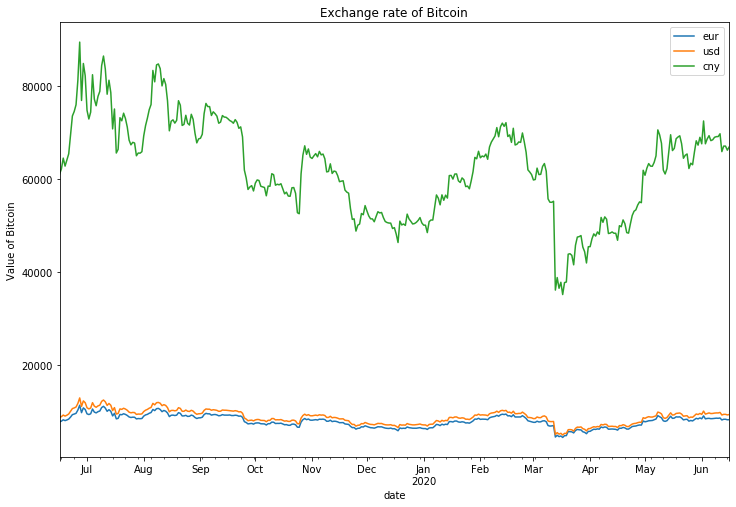

In [12]:
df_compare_bc.plot(figsize=(12,8))

plt.title(label='Exchange rate of Bitcoin')
plt.ylabel('Value of Bitcoin')



## The above graph is misleading because of the exchange rates between these currencies
## So we'll normalize by converting everything to Euro values

- Using a currency converter API from https://exchangeratesapi.io/

In [13]:
# Access API to convert currencies to EURO by historic exchange rates

api_exchange_rate = 'https://api.exchangeratesapi.io/history?start_at=2019-06-16&end_at=2020-06-16&symbols=USD,CNY'

json_dict = to_json_format(api_exchange_rate)


In [14]:
# Converting dict of dicts to list of dicts

def dicts_to_json(j_dict):
    dict_key = next(iter(j_dict))
    json_list = json_dict[dict_key]
    return json_list 

exchange_json = dicts_to_json(json_dict)


In [15]:
# Changing current index to 'date' column and adding number index
def change_df_index(json):
    df = pd.DataFrame.from_dict(json, orient='index')
    df = df.reset_index()
    
    return df

df_exchange = change_df_index(exchange_json)

df_exchange.head()

,index,CNY,USD
0,2019-06-28,7.8185,1.1380
1,2019-07-15,7.7484,1.1269
2,2020-06-04,8.0066,1.1250
3,2019-09-23,7.8279,1.0985
4,2019-07-04,7.7567,1.1288


In [16]:
# Renaming columns

def rename_cols(df):
    cols = df.columns
    
    cols = [''.join(col + '_to_eur').lower() if col != 'index' else 'date' for col in cols]
    
    return cols

df_exchange.columns = rename_cols(df_exchange)
df_exchange.head()


,date,cny_to_eur,usd_to_eur
0,2019-06-28,7.8185,1.1380
1,2019-07-15,7.7484,1.1269
2,2020-06-04,8.0066,1.1250
3,2019-09-23,7.8279,1.0985
4,2019-07-04,7.7567,1.1288


In [17]:
# Converting 'date' column to datetime dtype

df_exchange['date'] = pd.to_datetime(df_exchange['date'])
df_exchange.dtypes

date          datetime64[ns]
cny_to_eur           float64
usd_to_eur           float64
dtype: object

In [18]:
# Sorting values by date

df_exchange = df_exchange.sort_values(by=['date'])

In [19]:
df_exchange.head()

,date,cny_to_eur,usd_to_eur
58,2019-06-17,7.7794,1.1234
35,2019-06-18,7.7486,1.1187
170,2019-06-19,7.7378,1.1207
129,2019-06-20,7.7502,1.1307
67,2019-06-21,7.7792,1.1316


In [20]:
# resetting indices

df_exchange = df_exchange.reset_index(drop=True)
df_exchange.head()


,date,cny_to_eur,usd_to_eur
0,2019-06-17,7.7794,1.1234
1,2019-06-18,7.7486,1.1187
2,2019-06-19,7.7378,1.1207
3,2019-06-20,7.7502,1.1307
4,2019-06-21,7.7792,1.1316


## Now we'll merge the df_exchange with df_compare_bc

- We need to pay attention to the missing dates from df_exchange, because cryptocurrencies don't close on weekends.
- We'll fill the empty dates from the real world currencies with the last known exchange rate (i.e. Fridays' rates)
- Then we need to mconvert the USD and CNY values according to their exchange rates 

In [21]:
# Now I see I didn't need to reset the indices, but I'll leave it in to show I can do it
# Setting date column as index to match df_compare_bc dataframe

df_exchange.set_index('date', inplace=True)

df_exchange.head()


,cny_to_eur,usd_to_eur
date,,
2019-06-17,7.7794,1.1234
2019-06-18,7.7486,1.1187
2019-06-19,7.7378,1.1207
2019-06-20,7.7502,1.1307
2019-06-21,7.7792,1.1316


In [22]:
df_crypto_exchange = df_compare_bc.join(df_exchange)
df_crypto_exchange.head(20)

,eur,usd,cny,cny_to_eur,usd_to_eur
date,,,,,
2019-06-16,7853.059952,8818.609507,61072.398279,NaN,NaN
2019-06-17,8006.856370,8978.772588,62183.333561,7.7794,1.1234
2019-06-18,8298.389613,9312.868295,64499.063236,7.7486,1.1187
2019-06-19,8121.834445,9094.021746,62778.760320,7.7378,1.1207
2019-06-20,8264.077225,9285.928674,64106.337196,7.7502,1.1307
2019-06-21,8453.609849,9548.314565,65424.096570,7.7792,1.1316
2019-06-22,8886.277180,10118.359456,69512.724726,NaN,NaN
2019-06-23,9401.415893,10704.922148,73542.386961,NaN,NaN
2019-06-24,9528.776437,10846.125100,74511.794822,7.8354,1.1394


In [23]:
df_crypto_exchange.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2019-06-16 to 2020-06-16
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eur         367 non-null    float64
 1   usd         367 non-null    float64
 2   cny         367 non-null    float64
 3   cny_to_eur  256 non-null    float64
 4   usd_to_eur  256 non-null    float64
dtypes: float64(5)
memory usage: 27.2 KB


In [24]:
# Now it's time to fill the NaN values with the preceding values. In the case of the first row, 
# we'll use the succeeding value

df_crypto_exchange = df_crypto_exchange.fillna(method='ffill')
df_crypto_exchange = df_crypto_exchange.fillna(method='bfill')
df_crypto_exchange.head(20)

,eur,usd,cny,cny_to_eur,usd_to_eur
date,,,,,
2019-06-16,7853.059952,8818.609507,61072.398279,7.7794,1.1234
2019-06-17,8006.856370,8978.772588,62183.333561,7.7794,1.1234
2019-06-18,8298.389613,9312.868295,64499.063236,7.7486,1.1187
2019-06-19,8121.834445,9094.021746,62778.760320,7.7378,1.1207
2019-06-20,8264.077225,9285.928674,64106.337196,7.7502,1.1307
2019-06-21,8453.609849,9548.314565,65424.096570,7.7792,1.1316
2019-06-22,8886.277180,10118.359456,69512.724726,7.7792,1.1316
2019-06-23,9401.415893,10704.922148,73542.386961,7.7792,1.1316
2019-06-24,9528.776437,10846.125100,74511.794822,7.8354,1.1394


In [25]:
# Reordering columns
cols = ['eur', 'cny', 'cny_to_eur', 'usd', 'usd_to_eur']

df_crypto_exchange = df_crypto_exchange[cols]

df_crypto_exchange.head()

,eur,cny,cny_to_eur,usd,usd_to_eur
date,,,,,
2019-06-16,7853.059952,61072.398279,7.7794,8818.609507,1.1234
2019-06-17,8006.856370,62183.333561,7.7794,8978.772588,1.1234
2019-06-18,8298.389613,64499.063236,7.7486,9312.868295,1.1187
2019-06-19,8121.834445,62778.760320,7.7378,9094.021746,1.1207
2019-06-20,8264.077225,64106.337196,7.7502,9285.928674,1.1307


In [26]:
# Now to convert usd and cny to euro by their exchange rates

df_crypto_exchange['cny_eur_val'] = df_crypto_exchange['cny'] / df_crypto_exchange['cny_to_eur']

df_crypto_exchange.head()

,eur,cny,cny_to_eur,usd,usd_to_eur,cny_eur_val
date,,,,,,
2019-06-16,7853.059952,61072.398279,7.7794,8818.609507,1.1234,7850.528097
2019-06-17,8006.856370,62183.333561,7.7794,8978.772588,1.1234,7993.332848
2019-06-18,8298.389613,64499.063236,7.7486,9312.868295,1.1187,8323.963456
2019-06-19,8121.834445,62778.760320,7.7378,9094.021746,1.1207,8113.257039
2019-06-20,8264.077225,64106.337196,7.7502,9285.928674,1.1307,8271.571985


In [27]:
df_crypto_exchange['usd_eur_val'] = df_crypto_exchange['usd'] / df_crypto_exchange['usd_to_eur']

df_crypto_exchange.head()

,eur,cny,cny_to_eur,usd,usd_to_eur,cny_eur_val,usd_eur_val
date,,,,,,,
2019-06-16,7853.059952,61072.398279,7.7794,8818.609507,1.1234,7850.528097,7849.928349
2019-06-17,8006.856370,62183.333561,7.7794,8978.772588,1.1234,7993.332848,7992.498298
2019-06-18,8298.389613,64499.063236,7.7486,9312.868295,1.1187,8323.963456,8324.723603
2019-06-19,8121.834445,62778.760320,7.7378,9094.021746,1.1207,8113.257039,8114.590654
2019-06-20,8264.077225,64106.337196,7.7502,9285.928674,1.1307,8271.571985,8212.548575


In [31]:
# Exporting relevant subset of df as json

df_bitcoin_norm = df_crypto_exchange[['eur', 'cny_eur_val', 'usd_eur_val']]
df_bitcoin_norm.to_json('../data/clean_bitcoin_exchange_normalised.json')

## Now we can plot a more accurate graph that displays the values of Bitcoin
## in different currencies (EUR, CNY, USD)

In [30]:
# Get the relevant columns

df_to_plot = df_crypto_exchange[['eur', 'cny_eur_val', 'usd_eur_val']]
df_to_plot.head()

,eur,cny_eur_val,usd_eur_val
date,,,
2019-06-16,7853.059952,7850.528097,7849.928349
2019-06-17,8006.856370,7993.332848,7992.498298
2019-06-18,8298.389613,8323.963456,8324.723603
2019-06-19,8121.834445,8113.257039,8114.590654
2019-06-20,8264.077225,8271.571985,8212.548575


Text(0, 0.5, 'Value of Bitcoin')

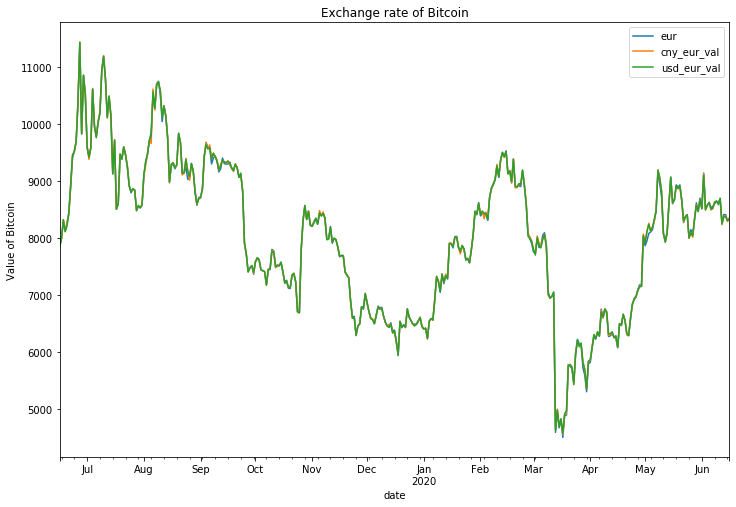

In [33]:
# And now to plot a more accurate visualisation

df_to_plot.plot(figsize=(12,8))

plt.title(label='Exchange rate of Bitcoin')
plt.ylabel('Value of Bitcoin')


## Let's turn the currency conversion into a function

In [ ]:
def get_exchange_api(currencies: list):
    api = ''.join('https://api.exchangeratesapi.io/history?start_at=2019-06-16&end_at=2020-06-16&symbols=' + ",".join(currencies))
    result = requests.get(api)
    json = result.json()

    return (json)

get_exchange_api(['CNY','USD'])